In [1]:
import pandas
import numpy as np
import pylab as pl
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   astropy.table import Table, join
from   astropy.convolution import convolve, Gaussian1DKernel
from   desiutil.dust import mwdust_transmission

## Set where to write Lya ensemble dflux.

In [2]:
outdir = '/project/projectdirs/desi/users/mjwilson/lya/'

## Load a set of Vi'd Lya QSOs.

In [3]:
dat = fits.open('/project/projectdirs/desi/spectro/redux/cascades/tiles/80609/deep/coadd-0-80609-deep.fits')

In [4]:
dat.info()

Filename: /project/projectdirs/desi/spectro/redux/cascades/tiles/80609/deep/coadd-0-80609-deep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      36   ()      
  1  FIBERMAP      1 BinTableHDU    196   500R x 92C   [K, I, J, K, J, J, D, D, E, E, E, E, K, B, 3A, I, J, D, J, 4A, E, E, E, E, E, E, K, 2A, E, E, E, E, E, E, E, E, E, E, E, E, E, I, E, E, E, E, 1A, K, K, K, K, K, J, J, 8A, J, E, E, E, E, K, K, K, K, J, I, E, E, E, E, E, E, E, D, D, E, E, J, J, I, J, J, I, J, J, I, J, J, I, E, E, I]   
  2  B_WAVELENGTH    1 ImageHDU        10   (2751,)   float64   
  3  B_FLUX        1 ImageHDU        11   (2751, 500)   float32   
  4  B_IVAR        1 ImageHDU        11   (2751, 500)   float32   
  5  B_MASK        1 ImageHDU        12   (2751, 500)   int32 (rescales to uint32)   
  6  B_RESOLUTION    1 ImageHDU        11   (2751, 11, 500)   float32   
  7  R_WAVELENGTH    1 ImageHDU        10   (2326,)   float64   
  8  R_FLUX        1 Ima

In [5]:
vi = pandas.read_csv('/project/projectdirs/desi/sv/vi/TruthTables/Blanc/QSO/desi-vi_QSO_tile80609_nightdeep_merged_all_210210_ADDING_object_info.csv')

In [6]:
vi

,TARGETID,Redrock_z,best_z,best_quality,Redrock_spectype,best_spectype,all_VI_issues,all_VI_comments,merger_comment,N_VI,...,TARGET_DEC,FIBER,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,EBV,TILEID
0,39627829524039394,1.6931,1.69310,0.5,GALAXY,GALAXY,NaN,NaN,none,2,...,1.752923,438,0.385813,0.515996,0.598839,0.300336,0.401676,0.466165,0.016876,80609
1,39627829524040643,2.2691,2.26910,4.0,QSO,QSO,NaN,Broad absorption line quasar (BAL),none,2,...,1.667771,135,0.530947,0.741242,1.180120,0.413092,0.576708,0.918168,0.019317,80609
2,39627829524041987,0.4703,0.47030,4.0,GALAXY,GALAXY,NaN,Very strong lines,none,2,...,1.782316,129,0.926231,1.061355,1.531378,0.720136,0.825194,1.190633,0.018266,80609
3,39627829524042026,1.5114,1.51140,0.5,GALAXY,GALAXY,NaN,NaN,none,2,...,1.721449,131,0.736039,0.890336,1.164051,0.572194,0.692145,0.904929,0.019181,80609
4,39627829524042121,1.6035,3.54675,3.5,GALAXY,QSO,CR,4th fit is good,none,2,...,1.853810,446,0.628459,1.322023,1.568953,0.489187,1.029050,1.221258,0.018016,80609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118,39627841595248046,0.9432,0.94320,4.0,GALAXY,GALAXY,NaN,NaN,none,2,...,2.343083,1747,0.346839,0.448074,0.705989,0.269614,0.348309,0.548798,0.020171,80609
1119,39627841595248587,1.6575,1.65750,2.5,GALAXY,GALAXY,NaN,NaN,One strong line must be at high-z but redshift...,2,...,2.258172,1706,0.341092,0.532386,0.512066,0.265190,0.413917,0.398118,0.019781,80609
1120,39627841595249678,0.0003,0.00030,4.0,STAR,STAR,NaN,NaN,none,2,...,2.126899,1191,1.764386,2.992544,3.909347,1.373909,2.330262,3.044169,0.019548,80609
1121,39627841595249823,0.0000,0.00000,4.0,STAR,STAR,NaN,NaN,none,2,...,2.264804,1738,-0.029482,0.035869,3.596277,0.000000,0.027899,2.797191,0.020232,80609


In [7]:
isin = (vi['best_spectype'] == 'QSO') & (vi['best_quality'] >= 2.5) & (vi['best_z'] >= 2.1)

In [8]:
vi = vi[isin]

In [9]:
vi

,TARGETID,Redrock_z,best_z,best_quality,Redrock_spectype,best_spectype,all_VI_issues,all_VI_comments,merger_comment,N_VI,...,TARGET_DEC,FIBER,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,EBV,TILEID
1,39627829524040643,2.2691,2.26910,4.0,QSO,QSO,NaN,Broad absorption line quasar (BAL),none,2,...,1.667771,135,0.530947,0.741242,1.180120,0.413092,0.576708,0.918168,0.019317,80609
4,39627829524042121,1.6035,3.54675,3.5,GALAXY,QSO,CR,4th fit is good,none,2,...,1.853810,446,0.628459,1.322023,1.568953,0.489187,1.029050,1.221258,0.018016,80609
27,39627829540814899,3.0990,3.09900,4.0,QSO,QSO,NaN,NaN,none,2,...,1.679209,4114,1.767022,2.544136,2.797342,1.375546,1.980493,2.177602,0.025355,80609
35,39627829540818607,2.1667,2.16670,4.0,QSO,QSO,NaN,NaN,none,2,...,1.636106,4049,7.910844,8.692345,11.444419,6.149510,6.757012,8.896341,0.034550,80609
38,39627829540819238,2.7314,2.73140,4.0,QSO,QSO,NaN,NaN,none,2,...,1.710213,4010,0.266408,0.374916,0.364012,0.207084,0.291430,0.282953,0.033394,80609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,39627841578471589,3.5778,3.57780,4.0,QSO,QSO,NaN,NaN,none,2,...,2.289424,1616,0.238451,0.522317,0.511614,0.185707,0.406783,0.398447,0.039358,80609
1098,39627841582664996,2.2188,2.21880,4.0,QSO,QSO,NaN,NaN,none,2,...,2.127683,1107,19.235744,20.937107,30.188473,14.977990,16.302763,23.506376,0.023028,80609
1099,39627841582665660,2.2390,2.23900,4.0,QSO,QSO,NaN,Broad absorption line quasar (BAL),none,2,...,2.293336,1869,3.223135,3.265966,3.875417,2.509646,2.542995,3.017535,0.024471,80609
1102,39627841586856489,2.1635,2.16350,4.0,QSO,QSO,NaN,Damped Lyman-alpha system (DLA) Broad absorpti...,none,2,...,2.262122,1899,0.482147,1.053065,2.595857,0.375379,0.819870,2.021020,0.020108,80609


In [10]:
tids = vi['TARGETID']

In [11]:
gauss_kernel = Gaussian1DKernel(15)

In [12]:
isin = np.isin(dat['FIBERMAP'].data['TARGETID'], tids)

In [13]:
fmap_ids = dat['FIBERMAP'].data['TARGETID'][isin]

In [14]:
nin = np.count_nonzero(fmap_ids)

In [15]:
gmags = 22.5 - 2.5*np.log10(dat['FIBERMAP'].data['FLUX_G'][isin] / mwdust_transmission(dat['FIBERMAP'].data['EBV'][isin], 'G', dat['FIBERMAP'].data['PHOTSYS'][isin]))

In [16]:
gmags

array([23.14369069, 23.30901504, 21.73717034, 20.97260533, 19.49456414,
       23.26627334, 22.9816093 , 21.85685729, 21.9456096 , 23.12395454,
       22.9451619 ])

# Our QSOs

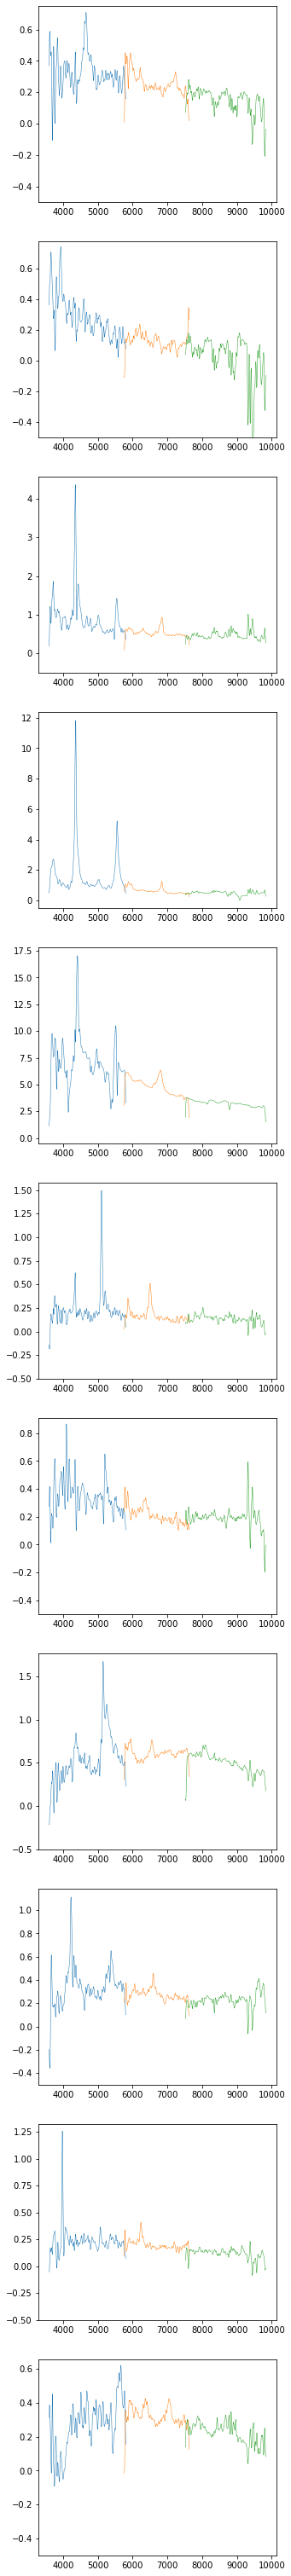

In [17]:
fig, axes = plt.subplots(nin, 1, figsize=(5, 5 * nin))

for band in ['B','R','Z']:
    for i, x in enumerate(dat['{}_FLUX'.format(band)].data[isin]):
        axes[i].plot(dat['{}_WAVELENGTH'.format(band)].data,  convolve(x, gauss_kernel), lw=0.5)
        axes[i].set_ylim(bottom=-0.5)

# Take closest to g=22 to be our reference.

In [18]:
# Closest to 22.
master_fluxes = {'gmag': gmags[7], 'tid': fmap_ids[7]}

for band in ['B', 'R', 'Z']:
    master_fluxes[band] = {'wave': dat['{}_WAVELENGTH'.format(band)].data, 'smoothflux': convolve(dat['{}_FLUX'.format(band)].data[isin][7], gauss_kernel), 'ivar': dat['{}_IVAR'.format(band)].data[isin][7]}

In [19]:
master_fluxes['tid']

39627817440251438

In [20]:
master_fluxes['gmag']

21.85685729142697

In [21]:
vi[vi['TARGETID'] == master_fluxes['tid']]

,TARGETID,Redrock_z,best_z,best_quality,Redrock_spectype,best_spectype,all_VI_issues,all_VI_comments,merger_comment,N_VI,...,TARGET_DEC,FIBER,FLUX_G,FLUX_R,FLUX_Z,FIBERFLUX_G,FIBERFLUX_R,FIBERFLUX_Z,EBV,TILEID
895,39627817440251438,3.2105,3.2305,4.0,QSO,QSO,NaN,NaN,Slight redshift tweak,3,...,1.292851,133,1.696957,2.237144,2.549719,1.320867,1.741335,1.984635,0.021008,80609


In [22]:
master_fluxes['z'] = vi[vi['TARGETID'] == master_fluxes['tid']]['best_z']

In [23]:
master_fluxes['continuum'] = 0.43

Text(0, 0.5, '1.e-17 ergs/s/cm2/A')

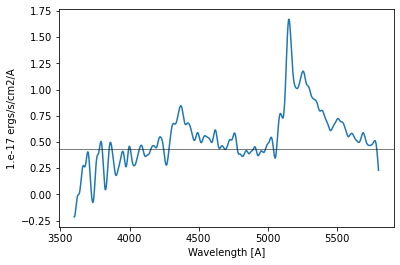

In [24]:
pl.plot(master_fluxes['B']['wave'], master_fluxes['B']['smoothflux'])
pl.axhline(master_fluxes['continuum'], c='k', lw=0.5)

pl.xlabel('Wavelength [A]')
pl.ylabel('1.e-17 ergs/s/cm2/A')

## Later we use this (by eye) 'continuum' as our asymptotic 'signal' normalization at the blue end.

## Get a QSO n(z)

In [25]:
# https://desi.lbl.gov/svn/code/desimodel/tags/0.14.0/data/targets/nz_qso.dat; 
# Number per sq. deg. per dz=0.1
# Note: Cascades
zlo, zhi, Nz = np.loadtxt('/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.14.0/data/targets/nz_qso.dat', unpack=True)

In [26]:
zmid = 0.5 * (zlo + zhi)

In [27]:
Nz /= Nz.max()

Text(0.5, 0, 'z')

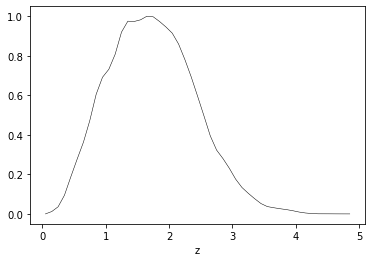

In [28]:
pl.plot(zmid, Nz, c='k', lw=0.5)
pl.xlabel('z')

In [29]:
zs = np.random.uniform(0.0, 5.0, 500000)
zs = np.sort(zs)

In [30]:
# pl.hist(zs, bins=np.arange(0.0, 5.0, 0.1))

In [31]:
draws = np.random.uniform(0.0, 1.0, 500000)

In [32]:
idx = np.digitize(zs, bins=np.arange(0.0, 5.1, 0.1))

In [33]:
probs = np.zeros_like(idx, dtype=np.float)

In [34]:
for i, uid in enumerate(np.unique(idx)[:-1]):
    probs[idx == uid] = Nz[i]

In [35]:
draws

array([0.11374124, 0.08788356, 0.31034525, ..., 0.43908733, 0.66715796,
       0.05194178])

In [36]:
probs

array([1.10132075e-10, 1.10132075e-10, 1.10132075e-10, ...,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [37]:
isin = draws <= probs

In [38]:
qso_zs = zs[isin]

## Here we've drawn an ensemble of zs from this distribution.

Text(0.5, 0, 'z')

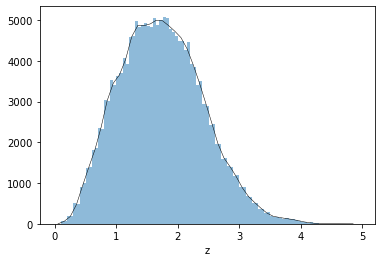

In [39]:
pl.plot(zmid, 5000. * Nz, c='k', lw=0.5)
pl.hist(qso_zs, bins=np.arange(0.0, 5.0, 0.05), alpha=0.5)
pl.xlabel('z')

In [40]:
lya_zs = qso_zs[qso_zs > 2.1]

In [41]:
lya_zs 

array([2.1000072 , 2.10001163, 2.10004188, ..., 4.67631916, 4.79821366,
       4.80214468])

In [42]:
# lya_zs = lya_zs[:2]

In [43]:
# 1216. * (1. + lya_zs)

In [44]:
nlya = len(lya_zs)

###  Our 'signal' will be unity bluer than Lya for a given redshift (zero otherwise).  We then stack across the ensemble.

<ipython-input-45-f174782ff96a>:19: RuntimeWarning: invalid value encountered in true_divide
  zfactor /= np.sum(zfactor)
<ipython-input-45-f174782ff96a>:19: RuntimeWarning: invalid value encountered in true_divide
  zfactor /= np.sum(zfactor)


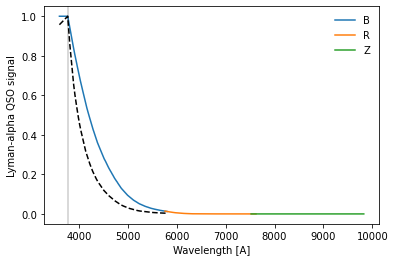

In [45]:
bands      = ['B', 'R', 'Z']

for band in bands:
    wave   = dat['{}_WAVELENGTH'.format(band)].data
    nwave  = wave[:,None] * np.ones(nlya, dtype=float)[None,:]
    
    weight = np.zeros(shape=(len(wave), nlya), dtype=float)
    
    for i, z in zip(range(nlya), lya_zs):
        weight[nwave[:,i] < (1. + z) * 1216., i] = 1.0

    mweight = np.mean(weight, axis=1)    
    pl.plot(wave, mweight, label='{}'.format(band)) 

    for i, z in zip(range(nlya), lya_zs):    
        zabs     = (wave / 1216.) - 1.
        zfactor  = (1. + zabs)**(3.8/4.)   
        zfactor[wave > (1. + z) * 1216.] = 0.          
        zfactor /= np.sum(zfactor)
            
        weight[:,i] *= zfactor

    zweight = np.mean(weight, axis=1)           
    
    if band == 'B':
        pivot  = (1. + 2.1) * 1216.
        znorm  = zweight[np.where(np.abs(wave - pivot) == np.abs(wave - pivot).min())[0]]
    
    zweight /= znorm
    
    pl.plot(wave, zweight, label='', linestyle='--', c='k') 
        
    pl.axvline(1216. * 3.1, lw=0.1, c='k')
    pl.xlabel('Wavelength [A]')
    pl.ylabel('Lyman-alpha QSO signal')
    pl.legend(frameon=False)

### To DO:  the normalization of the z weighting (artifically?) drives the weighting lower rather than higher.  As, for high z, a greater wavelength range is available and the normalization is a large factor.  Figure this out.

Text(0, 0.5, '1.e-17 ergs/s/cm2/A')

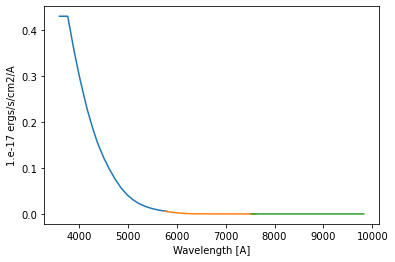

In [57]:
tracer        = 'LYA'

hdr           = fits.Header()
hdr['NMODEL'] = nlya
hdr['TRACER'] = tracer
hdr['FILTER'] = 'decam2014-g'
hdr['ZLO']    = 2.1
        
hdu_list      = [fits.PrimaryHDU(header=hdr)]

for band in ['b', 'r', 'z']:
    wave   = dat['{}_WAVELENGTH'.format(band)].data
    nwave  = wave[:,None] * np.ones(nlya, dtype=float)[None,:]
    
    weight = np.zeros(shape=(len(wave), nlya), dtype=float)
    
    for i, z in zip(range(nlya), lya_zs):
        weight[nwave[:,i] < (1. + z) * 1216., i] = 1.0
    
    weight   = np.mean(weight, axis=1)
    weight   = np.expand_dims(master_fluxes['continuum'] * weight, axis=0)
    
    pl.plot(wave, weight[0])
        
    hdu_list.append(fits.ImageHDU(wave, name='WAVE_{}'.format(band.upper())))
    hdu_list.append(fits.ImageHDU(weight, name='DFLUX_{}'.format(band.upper())))

hdu_list = fits.HDUList(hdu_list)
hdu_list.writeto('{}/tsnr-ensemble-{}.fits'.format(outdir, tracer.lower()), overwrite=True)

pl.xlabel('Wavelength [A]')
pl.ylabel('1.e-17 ergs/s/cm2/A')

###  Finally, here we've used our reference continuum from above as the blue end normalization and write to disk at outdir.

## Check against QSO tsnr. 

In [53]:
ens = fits.open('/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.14.0/data/tsnr/tsnr-ensemble-qso.fits')

In [54]:
ens.info()

Filename: /global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/code/desimodel/0.14.0/data/tsnr/tsnr-ensemble-qso.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      14   ()      
  1  WAVE_B        1 ImageHDU         7   (2751,)   float64   
  2  DFLUX_B       1 ImageHDU         8   (2751, 1)   float64   
  3  WAVE_R        1 ImageHDU         7   (2326,)   float64   
  4  DFLUX_R       1 ImageHDU         8   (2326, 1)   float64   
  5  WAVE_Z        1 ImageHDU         7   (2881,)   float64   
  6  DFLUX_Z       1 ImageHDU         8   (2881, 1)   float64   
  7  WEIGHTS       1 ImageHDU         8   (2, 1000)   float64   


In [55]:
ens['DFLUX_B'].shape

(1, 2751)

###  TODO: Non-critical (as resampled in tsnr.py), but followup on why the wavelength ranges to the other ensembles does not match reduction wavelengths now. 

# Done.